# <span style="color:blue">Processamento Analítico de Dados (em Larga Escala)</span>
# <span style="color:blue">Consultas Analíticas usando Spark SQL</span>

**Profa. Dra. Cristina Dutra de Aguiar**<br>

# 1 Definição da Constelação de Fatos

O *data mart* da aula é composto pelas seguintes tabelas de fatos e de dimensão:

**Tabelas de dimensão**

- data (dataPK, dataCompleta, dataDia, dataMes, dataBimestre, dataTrimestre, dataSemestre, dataAno)
- funcionario (funcPK, funcMatricula, funcNome, funcSexo, funcDataNascimento, funcDiaNascimento, funcMesNascimento, funcAnoNascimento, funcCidade, funcEstadoNome, funcEstadoSigla, funcRegiaoNome, funcRegiaoSigla, funcPaisNome, funcPaisSigla)
- equipe (equipePK, equipeNome, filialNome, filialCidade, filialEstadoNome, filialEstadoSigla, filialRegiaoNome, filialRegiaoSigla, filialPaisNome, filialPaisSigla)
- cargo (cargoPK, cargoNome, cargoRegimeTrabalho, cargoEscolaridadeMinima, cargoNivel)
- cliente (clientePK, clienteNomeFantasia, clienteSetor, clienteCidade, clienteEstadoNome, clienteEstadoSigla, clienteRegiaoNome, clienteRegiaoSigla, clientePaisNome, clientePaisSigla)

**Tabelas de fatos**
- pagamento (dataPK, funcPK, equipePK, cargoPK, salario, quantidadeLancamentos)
- negociacao (dataPK, equipePK, clientePK, receita, quantidadeNegociacoes)


# 2 Obtenção dos dados

In [1]:
#instalando o módulo wget

%%capture
!pip install -q wget
!mkdir data

import wget

In [2]:
#baixando os dados das tabelas de dimensão

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/data.csv"
wget.download(url, "data/data.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/funcionario.csv"
wget.download(url, "data/funcionario.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/equipe.csv"
wget.download(url, "data/equipe.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/cargo.csv"
wget.download(url, "data/cargo.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/cliente.csv"
wget.download(url, "data/cliente.csv")

'data/cliente.csv'

In [3]:
#baixando os dados das tabelas de fatos

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/pagamento.csv"
wget.download(url, "data/pagamento.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/negociacao.csv"
wget.download(url, "data/negociacao.csv")

'data/negociacao.csv'

# 3 Instalação e Conexão do Apache Spark Cluster

In [4]:
#instalando Java Runtime Environment (JRE) versão 11
%%capture
!apt-get remove -y openjdk*
!apt-get update --fix-missing
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

In [5]:
#baixando Apache Spark versão 3.4.0
%%capture
!wget https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar -xvzf spark-3.4.0-bin-hadoop3.tgz

In [6]:
import os
#configurando a variável de ambiente JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
#configurando a variável de ambiente SPARK_HOME
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
#configurando a variável de ambiente PATH
os.environ["PATH"] += ":/content/spark-3.4.0-bin-hadoop3/bin:/content/spark-3.4.0-bin-hadoop3/sbin"

In [7]:
%%capture
!pip install -q findspark==2.0.1
!pip install pyspark==3.4.0

In [8]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("pyspark-notebook").master("local[*]").getOrCreate()

from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import round, desc

In [9]:
#criando a sessão em Spark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("pyspark-notebook").master("local[*]").getOrCreate()

# 4 Preparação dos Dados


In [10]:
#gerando dataFrames em Spark

cargo = spark.read.csv(path="data/cargo.csv", header=True, sep=",")
cliente = spark.read.csv(path="data/cliente.csv", header=True, sep=",")
data = spark.read.csv(path="data/data.csv", header=True, sep=",")
equipe = spark.read.csv(path="data/equipe.csv", header=True, sep=",")
funcionario = spark.read.csv(path="data/funcionario.csv", header=True, sep=",")

pagamento = spark.read.csv(path="data/pagamento.csv", header=True, sep=",")
negociacao = spark.read.csv(path="data/negociacao.csv", header=True, sep=",")

In [11]:
negociacao.show(5)

+--------+---------+------+------------------+---------------------+
|equipePK|clientePK|dataPK|           receita|quantidadeNegociacoes|
+--------+---------+------+------------------+---------------------+
|       2|        9|    22|          11564.75|                    1|
|       2|       24|    11|           17990.5|                    1|
|       2|       28|    21|           16335.9|                    1|
|       1|       30|    23|           8495.55|                    1|
|       2|       43|    30|          24748.75|                    1|
|       2|       46|    21|           18591.8|                    1|
|       1|       51|    25|          21783.05|                    1|
|       1|       77|     4|          11182.95|                    1|
|       1|       83|    13|            8412.1|                    1|
|       2|      106|    17| 7694.700000000001|                    1|
|       1|      114|     6|          11324.75|                    1|
|       2|      125|    15|       

In [12]:
#visualizando os dados dos dataFrames em Spark

cargo.show(5)
cliente.show(5)
data.show(5)
equipe.show(5)
funcionario.show(5)

pagamento.show(5)
negociacao.show(5)

+-------+--------------------+-------------------+--------------------+-----------------------+----------+
|cargoPK|           cargoNome|cargoRegimeTrabalho|cargoJornadaTrabalho|cargoEscolaridadeMinima|cargoNivel|
+-------+--------------------+-------------------+--------------------+-----------------------+----------+
|      1|PROGRAMADOR DE SI...|         TEMPORARIO|                 20H|                  MEDIO|    JUNIOR|
|      2|PROGRAMADOR DE SI...|         TEMPORARIO|                 20H|               SUPERIOR|     PLENO|
|      3|PROGRAMADOR DE SI...|         TEMPORARIO|                 20H|                    POS|    SENIOR|
|      4|PROGRAMADOR DE SI...|         TEMPORARIO|                 40H|                  MEDIO|    JUNIOR|
|      5|PROGRAMADOR DE SI...|         TEMPORARIO|                 40H|               SUPERIOR|     PLENO|
+-------+--------------------+-------------------+--------------------+-----------------------+----------+
only showing top 5 rows

+---------+-

In [13]:
#criando visões temporárias para uso de SQL textual

cargo.createOrReplaceTempView("cargo")
cliente.createOrReplaceTempView("cliente")
data.createOrReplaceTempView("data")
equipe.createOrReplaceTempView("equipe")
funcionario.createOrReplaceTempView("funcionario")

pagamento.createOrReplaceTempView("pagamento")
negociacao.createOrReplaceTempView("negociacao")


# 5 Caracterização de Consultas OLAP


## 5.1 Operações Analíticas

**Drill-down**: Analisa os dados em níveis de agregação progressivamente mais detalhados, ou de menor granularidade.

**Roll-up**: Analisa os dados em níveis de agregação progressivamente menos detalhados, ou de maior granularidade.

**Slice and Dice**: Restringe os dados sendo analisados a um subconjunto desses dados. (i) slice: corte para um valor fixo; (ii) dice: seleção de faixas de valores.

**Pivot**: Reorienta a visão multidimensional dos dados, oferecendo diferentes perspectivas dos mesmos dados.

**Drill-Across**: Compara medidas numéricas de tabelas de fatos diferentes, utilizando pelo menos uma dimensão em comum.

## 5.2 Junção Estrela

Necessária devido à organização dos dados segundo os esquemas estrela, floco de neve e estrela-floco.

Consiste em acessar todas as **tabelas de fatos e de dimensão** envolvidas em uma consulta OLAP e realizar todas as **junções e agregações** necessárias, além de resolver as **condições de seleção** aplicadas sobre os predicados convencionais.

Na junção estrela, as junções são sempre realizadas em termos da tabela de fatos. Por exemplo:

**Primeiro Esquema Estrela**

*   pagamento.dataPK = data.dataPK
*   pagamento.funcPK = funcionario.funcPK
*   pagamento.equipePK = equipe.equipePK
*   pagamento.cargoPK = cargo.cargoPK

**Segundo Esquema Estrela**

*   negociacao.dataPK = data.dataPK
*   negociacao.equipePK = equipe.equipePK
*   negociacao.clientePK = cliente.clientePK


## 5.3 Cláusulas SQL

**Junção estrela**: FROM, pondedo usar:

*   FROM JOIN nomes das tabelas ON colunas de junção OU
*   FROM nomes das tabelas WHERE colunas de junção

**Drill-down**: GROUP BY.

**Roll-up**: GROUP BY.

**Slice and Dice**: WHERE.

**Pivot**: SELECT.

**Drill-Across**: JOIN e subconsultas.




# 6 Especificação de Consultas Analíticas

## 6.1 Consulta 1

Qual o total de despesas em salários nos anos de 2016 a 2020 em cada região na qual a equipe está localizada, considerando o cargo de nível junior?

In [14]:
query = """
SELECT dataAno AS ANO,
       filialRegiaoNome AS REGIAO,
       ROUND(SUM(salario),2) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK
               JOIN equipe ON equipe.equipePK = pagamento.equipePK
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
WHERE dataAno BETWEEN 2016 AND 2020
      AND cargoNivel = "JUNIOR"
GROUP BY dataAno, filialRegiaoNome
ORDER BY SUM(salario) DESC, dataAno DESC, filialRegiaoNome
"""

spark.sql(query).show()

+----+------------+----------------+
| ANO|      REGIAO|TOTAL DE DESPESA|
+----+------------+----------------+
|2020|     SUDESTE|      1257808.68|
|2019|     SUDESTE|      1257808.68|
|2018|     SUDESTE|      1056208.92|
|2017|     SUDESTE|       876154.56|
|2016|     SUDESTE|       489456.84|
|2020|CENTRO-OESTE|       337073.28|
|2019|CENTRO-OESTE|       337073.28|
|2018|CENTRO-OESTE|       337073.28|
|2020|    NORDESTE|        160832.4|
|2019|    NORDESTE|        160832.4|
|2017|CENTRO-OESTE|       154488.24|
+----+------------+----------------+



<Axes: ylabel='ANO,REGIAO'>

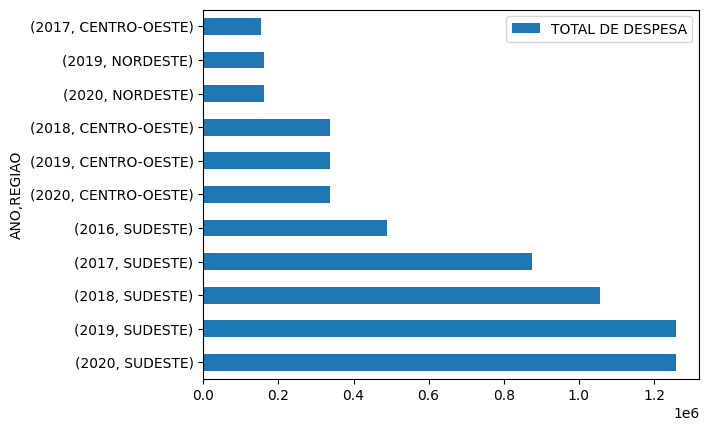

In [15]:
# transformando o resultado da consulta em Pandas
gastosRegiaoJunior = spark.sql(query).toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas
gastosRegiaoJunior.set_index(['ANO', 'REGIAO']).plot(kind = 'barh', stacked=True)

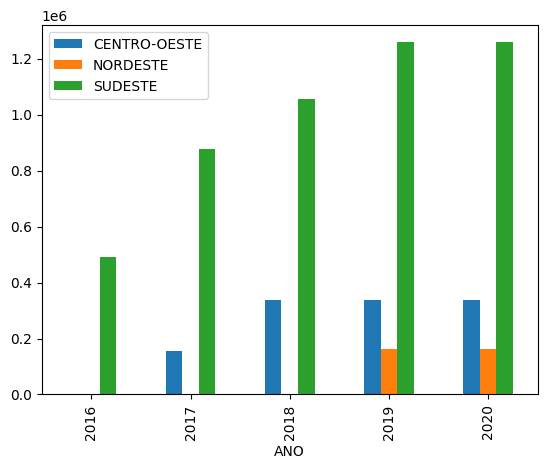

In [16]:
# visualizando os dados "quebrados" por região
legend = ['CENTRO-OESTE', 'NORDESTE', 'SUDESTE']
ax = gastosRegiaoJunior.set_index(['ANO', 'REGIAO']).unstack().plot(kind = 'bar')
ax.legend(legend); # atualiza os labels

## 6.2 Consulta 2

Por meio das respostas da Consulta 1, é possível identificar qual ano e qual região correspondem ao maior gasto em salários. Utilizando essa resposta, mostre qual o total de despesas em cada estado desta região.

Qual o total de despesas em salários no ano de 2020 em cada estado da região Sudeste, considerando o cargo de nível junior?

In [17]:
query = """
SELECT filialEstadoNome AS ESTADO,
       ROUND(SUM(salario), 2) AS `TOTAL DE DESPESA`
FROM pagamento JOIN data ON data.dataPK = pagamento.dataPK
               JOIN equipe ON equipe.equipePK = pagamento.equipePK
               JOIN cargo ON cargo.cargoPK = pagamento.cargoPK
WHERE dataAno = 2020
      AND cargoNivel = "JUNIOR"
      AND filialRegiaoNome = "SUDESTE"
GROUP BY filialEstadoNome
ORDER BY `TOTAL DE DESPESA` DESC
"""

spark.sql(query).show()

+--------------+----------------+
|        ESTADO|TOTAL DE DESPESA|
+--------------+----------------+
|     SAO PAULO|       796875.84|
|RIO DE JANEIRO|       460932.84|
+--------------+----------------+



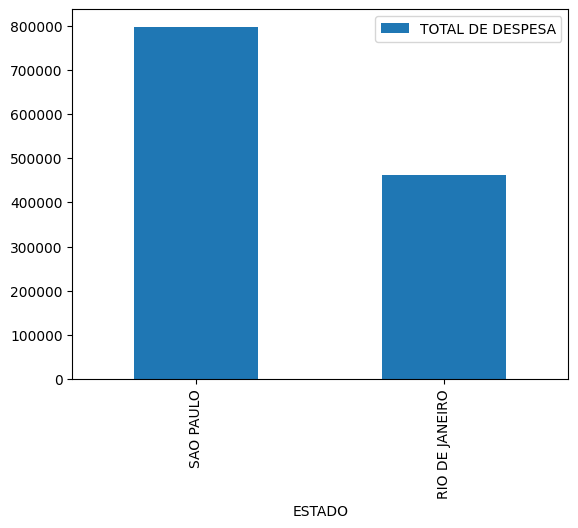

In [18]:
# transformando o resultado da consulta em Pandas
gastosEstadoSP = spark.sql(query).toPandas()

# exibindo a visualização gráfica
# informando quais são os índices do DataFrame em Pandas
ax = gastosEstadoSP.set_index(['ESTADO']).plot(kind = 'bar')

## 6.3 Consulta 3

Por meio das respostas da Consulta 2, é possível identificar qual estado possui maior gasto em salários. Utilizando essa resposta, mostre qual o total de despesas por sexo para esse estado.  

Qual o total de despesas em salários por sexo para o ano de 2020, o estado de São Paulo da região Sudeste e o cargo de nível junior?

In [19]:
# Exercício: fazer a resposta
query = """

"""

spark.sql(query).show()

ParseException: 
[PARSE_SYNTAX_ERROR] Syntax error at or near end of input.(line 3, pos 0)

== SQL ==
^^^


## 6.4 Consulta 4

Qual a média de gastos com salários e qual a média de receitas recebidas, considerando cada ano?

In [20]:
query = """
SELECT anoPag AS `Ano`,
       ROUND(salario,2) AS `Gasto com Salários`,
       ROUND(receita,2) AS `Receitas Recebidas`,
       ROUND(receita,2) - ROUND(salario,2) AS LUCRO
FROM ( SELECT dataAno, AVG(salario)
       FROM pagamento JOIN data on data.dataPK = pagamento.dataPK
       GROUP BY dataAno
      ) AS pag(anoPag, salario)
     JOIN
     ( SELECT dataAno, AVG(receita)
       FROM negociacao JOIN data ON data.dataPK = negociacao.dataPK
       GROUP BY dataAno
      ) AS neg(anoNeg, receita)
     ON anoPag = anoNeg
ORDER BY anoPag
"""

spark.sql(query).show()

+----+------------------+------------------+------------------+
| Ano|Gasto com Salários|Receitas Recebidas|             LUCRO|
+----+------------------+------------------+------------------+
|2016|           7404.36|          17026.74| 9622.380000000001|
|2017|           7405.51|          13408.61|            6003.1|
|2018|           7778.92|          13655.52|            5876.6|
|2019|           7736.53|           28930.7|21194.170000000002|
|2020|           7736.53|          26698.04|18961.510000000002|
+----+------------------+------------------+------------------+



## 6.5 Desafio

Descubra quais cláusulas SQL foram propostas para gerar diferentes níveis de agregação. Utilizando essas cláusulas, faça consultas que mostrem qual a média dos salários por ano, considerando equipes localizadas na região sudeste.

In [ ]:
# Exercício: fazer a resposta
query = """

"""

spark.sql(query).show()